##### [sample solution that works]

# This tutorial will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="Skiing-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 15

In [3]:

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)
from scipy.misc import imresize
def preprocess(obs):
    obs= imresize(obs,IMAGE_SIZE)
    return obs.mean(-1)/255.

[2017-01-23 23:27:51,469] Making new env: Skiing-v0


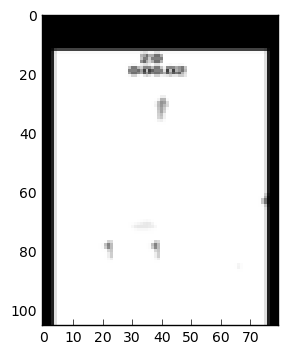

In [4]:
import gym

#creating a game
atari = gym.make(GAME)

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(preprocess(obs),interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import theano
theano.config.floatX = 'float32'
import lasagne

Using gpu device 0: GeForce 840M (CNMeM is disabled, cuDNN not available)


In [6]:
from lasagne.layers import InputLayer

#image observation at current tick goes here, shape = (sample_i,x,y)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))

In [7]:
from agentnet.memory import WindowAugmentation,LSTMCell

#store 4-tick window in order to perceive motion of objects
prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))

#update rule for this window
current_window = WindowAugmentation(observation_layer,prev_window)

In [19]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
#<build network body here>
nn = Conv2DLayer(current_window, num_filters=32, filter_size=(3,3))
nn = Pool2DLayer(nn, pool_size=2)

#please set this to your last layer for convenience
last_layer = DenseLayer(nn, num_units=32)

In [20]:
#a layer that predicts Qvalues for all actions.
# Just adense layer with corresponding number of units and no nonlinearity (lasagne.nonlinearity.linear)
n_actions = atari.action_space.n
qvalues_layer = DenseLayer(last_layer,
                num_units = n_actions,
                nonlinearity=lasagne.nonlinearities.linear)

In [21]:
#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver

action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")
action_layer.epsilon.set_value(np.float32(0.1))

In [22]:
#Since it's a single lasagne network, one can get it's weights the regular way
weights = lasagne.layers.get_all_params(action_layer,trainable=True)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [23]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,                    #observations
              policy_estimators=(qvalues_layer),                       #whatever else you want to monitor
              action_layers=action_layer,                               #actions
              agent_states={current_window:prev_window},               #dict of memory states
              )


# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [24]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,preprocess_observation=preprocess) #see docs on what it's capabale of

[2017-01-23 23:31:34,521] Making new env: Skiing-v0
[2017-01-23 23:31:34,622] Making new env: Skiing-v0
[2017-01-23 23:31:34,772] Making new env: Skiing-v0
[2017-01-23 23:31:34,916] Making new env: Skiing-v0
[2017-01-23 23:31:35,047] Making new env: Skiing-v0
[2017-01-23 23:31:35,141] Making new env: Skiing-v0
[2017-01-23 23:31:35,233] Making new env: Skiing-v0
[2017-01-23 23:31:35,323] Making new env: Skiing-v0
[2017-01-23 23:31:35,436] Making new env: Skiing-v0
[2017-01-23 23:31:35,544] Making new env: Skiing-v0


In [25]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)

print(action_names[action_log][:2])
print(reward_log[:2])

[['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'NOOP']
 ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT' 'RIGHT']]
[[-7. -3. -5. -7. -6. -4.  0.]
 [-7. -3. -7. -5. -6. -5.  0.]]
CPU times: user 616 ms, sys: 48 ms, total: 664 ms
Wall time: 664 ms


In [26]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Demo run

In [27]:
action_layer.epsilon.set_value(0)
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-01-23 23:31:46,621] Making new env: Skiing-v0
[2017-01-23 23:31:46,732] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-23 23:31:46,736] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-01-23 23:31:46,795] Starting new video recorder writing to /home/anya/ipython/ml_seminars/records/openaigym.video.1.13502.video000000.mp4
[2017-01-23 23:33:51,751] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anya/ipython/ml_seminars/records')


Episode finished after 5997 timesteps with reward=-30000.0


In [17]:
from IPython.display import HTML
import os
from random import choice
video_path = choice([os.path.join("records",fname) 
                     for fname in os.listdir("records") 
                     if fname.endswith(".mp4")])


HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Q-learning
* Get reference Qvalues according to Qlearning algorithm
* Train on environment interaction sessions
 * Such sessions are sequences of observations, agent memory, actions, q-values,etc
* Implement Q-learning loss & minimize it

In [62]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay

_,_,_,_,qvalues_seq, = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)

AssertionError: Some state variables has different dtype/shape from init .

In [63]:
import theano.tensor as T

#actions, shape= [batch_i, time_tick]
actions = replay.actions[0]

#rewards [batch_i,time_tick]
rewards = replay.rewards

#session indicator (0 means session ended) [batch_i,time_tick]
is_alive = replay.is_alive

#qvalues at current tick.  shape = [batch_i,time_tick, action_id]
qvalues = qvalues_seq

#q-values at next tick. shape = [batch_i,time_tick, action_id], padded with zeros for math simplicity
next_qvalues = T.concatenate([qvalues[:, 1:],
                              T.zeros_like(qvalues[:,:1,:]),],axis=1)



NameError: name 'qvalues_seq' is not defined

In [64]:
#clip rewards to [-1,+1] to avoid explosion.
rewards = <clip rewards to [-1,1] range. Alternatively, scale them or just mind your learning rates>

SyntaxError: invalid syntax (<ipython-input-64-6989593db05b>, line 2)

In [ ]:


#compute q-values for best actions
optimal_next_qvalues = 
#<qvalue for optimal action. Aggregate over next_qvalues>

gamma=0.99

# target Qvalues, r + gamma*max_a' Q(s', a')
reference_qvalues = <reference qvalues, r+gamma*Q(s_next,a_max)>

In [ ]:
from agentnet.learning.helpers import get_end_indicator

#indicator of session end [batch_i,time_tick]
is_end = get_end_indicator(is_alive)

#set reference qvalues at session end to just the immediate rewards
reference_qvalues = T.switch(is_end,rewards,reference_qvalues)

#consider constant
reference_qvalues = theano.gradient.disconnected_grad(reference_qvalues)

In [ ]:
from agentnet.learning.helpers import get_action_Qvalues

#q-values for chosen actions [batch_i,time_tick]
predicted_qvalues = get_action_Qvalues(qvalues,actions)

In [ ]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2 at each tick
elwise_mse_loss = <elementwise loss for Q-learning>

#exclude last tick (zeros)
elwise_mse_loss = T.set_subtensor(elwise_mse_loss[:,-1],0)

#compute mean over "alive" fragments
loss = (elwise_mse_loss*is_alive).sum() / is_alive.sum()

In [ ]:
# Compute weight updates. Replace with any optimizer you want
updates = <optimize loss over nn weights using your favorite algorithm>

In [ ]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [ ]:
def get_epsilon(epoch_counter):
    """
    a function which outputs current epsilon for e-greedy exploration given training iteration.
    """
    <implement me!>
    return 0.1

#a visualizer
plt.plot(np.linspace(0,50000),[get_epsilon(i) for i in np.linspace(0,50000)])

In [ ]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**7):    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = get_epsilon(epoch_counter)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    #train
    pool.update(SEQ_LENGTH)
    loss = train_step()
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        print("iter=%i\tepsilon=%.3f\tloss=%.3f"%(epoch_counter,current_epsilon,loss))
        
    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        action_layer.epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
import pandas as pd
t,r = zip(*sorted(rewards.items(),key=lambda k:k[0]))
plt.plot(t,pd.ewma(np.concatenate(r),alpha=0.1))
plt.title("moving average of rewards over ticks of training")

In [ ]:
action_layer.epsilon.set_value(0.05)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%np.mean(rw))

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


In [ ]:
from agentnet.utils.persistence import save,load
save(action_layer,"gopher.pcl")
#load(action_layer,"gopher.pcl")

# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__